<img src="https://raw.githubusercontent.com/DonAurelio/open-datacube-bac-training/main/docs/banner.png" alt="Deparatemento de Ingeniería de Sistemas y Computación, Universidad de los Andes">

#  Aplicación de algoritmos para  el análisis de coberturas

**Introducción**

Los compuestos temporales reducen la incidencia de lasnubes en imágenes de satélite. Para ello se realiza un proceso de selección de pixeles en una serie de tiempo para una imagen. Como resultado del proceso de selección, se obtiene una imagen o composición que contiene pixeles de diferentes periodos de tiempo. Estos píxeles son seleccionados mediante la aplicación de un criterio de selección de pixeles. Algunos métodos de selección de píxeles conocidos son: Most Recent / Least Recent Pixel, Maximum Value Composite (MVC), Median Composite, Geomedian Composite, Best Pixel, entre otros. En el presente notebook exploraremos uno de los compuestos mas conocidos, el compuesto de medianas.

**Contenido**

1. Importar librerías
2. Consulta del área de estudio
3. Cálculo del compuesto de medianas
4. Guardar resultados de análisis en fortamto netcdf
5. Guardar resultados de análisis en formato geotiff

## 1. Importar librerías

En esta sección se importan las librerías cuya funicionalidades particulares son requeridas.

In [16]:
# las funcionalidades del open data cube son accedidas 
# por medio de la librería datacube
import datacube

# Librería para cálculo en matrices
import numpy as np

# Manipulación de datasets
import xarray as xr

# Manipulación de datos raster
import rasterio

# Librería usada para la carga de polígonos
import geopandas as gpd

# Librería usada para visualización de datos
import matplotlib as mpl
import matplotlib.pyplot as plt

# Desactiva los warnings en el notebook
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Configuración de Drivers para leer polígonos en formato KMLs
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

## 2. Consulta del área de estudio

(Opción 1) Consultar un área a partir de un polígono

(5.9433156241219764, 5.947987873840771)
(-73.55008046294513, -73.54691072556433)


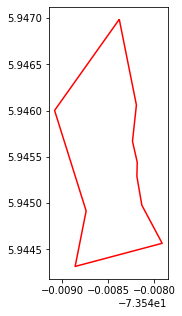

In [3]:
# Carga del archivo .kml
df_polygon = gpd.read_file("1.kml",driver='KML')
df_polygon = df_polygon.to_crs('EPSG:4326')

# Pintar el polígono seleccionado
fig, ax = plt.subplots(figsize=(5,5))
df_polygon.boundary.plot(ax=ax,color='red')

# Obtención de la geometría del polígono del GeoDataFrame
geometry_predio = df_polygon['geometry'][0]

# Obtención de los límites del cuadrado que enmarca el polígono
minx, miny, maxx, maxy = geometry_predio.bounds

# Aumento del aŕea del cuadrado para "EPSG:4326"
# 2 kilómetros
buffer = 0.001

minx = minx - buffer
miny = miny - buffer
maxx = maxx + buffer
maxy = maxy + buffer

# Parámetros de área a ser consultada
set_study_area_lat = (miny,maxy)
set_study_area_lon = (minx,maxx)

print(set_study_area_lat)
print(set_study_area_lon)

(Opción 2) Consultar un área a partir de un punto

Los coordenadas del punto a seleccionar pueden ser obtenidas a travez de herramientas GIS como google maps. Este punto debe estar comprendido en el área que desea estudiar. El punto definido será empleado para la generación de un cuadrado que finálmente será usado para consultar el área de estudio. La variable `buffer` permite ampliar o disminuir las dimensiones del cuadrado. Lo anterior es equivalente a disminuir o ampliar el área de estudio a consultar en el open data cube.

<img src="https://raw.githubusercontent.com/DonAurelio/open-datacube-bac-training/main/docs/latlong_buffer.png" alt="Definición área de estudio" width="20%">

In [4]:
# Definición de las coordenadas del punto
central_lat = 5.55215
central_lon = -72.93944

# Aumento del aŕea del cuadrado para "EPSG:4326"
buffer = 0.1

# Calculo del cuadro delimitador (bounding box) para el área de estudio
set_study_area_lat = (central_lat - buffer, central_lat + buffer)
set_study_area_lon = (central_lon - buffer, central_lon + buffer)

print(set_study_area_lat)
print(set_study_area_lon)

(5.4521500000000005, 5.65215)
(-73.03944, -72.83944000000001)


Consulta de información sobre el área de interes por medio del open data cube

In [9]:
dc = datacube.Datacube(app="Cana")

dataset = dc.load(
    product="s2_sen2cor_ard_granule_EO3",
    longitude=(-73.55008046294513, -73.54691072556433),
    latitude=(5.9433156241219764, 5.947987873840771),
    time=('2020-04-01', '2020-04-30'),
    measurements=["red","blue","green","nir","swir1","swir2","scl"],
    crs="EPSG:4326",
    output_crs="EPSG:4326",
    resolution=(-0.00008983111,0.00008971023)
)

dataset

<xarray.Dataset>
Dimensions:      (latitude: 53, longitude: 36, time: 12)
Coordinates:
  * time         (time) datetime64[ns] 2020-04-03T21:15:16 ... 2020-04-30T19:...
  * latitude     (latitude) float64 5.948 5.948 5.948 ... 5.944 5.943 5.943
  * longitude    (longitude) float64 -73.55 -73.55 -73.55 ... -73.55 -73.55
    spatial_ref  int32 4326
Data variables:
    red          (time, latitude, longitude) uint16 845 830 783 795 ... 0 0 0 0
    blue         (time, latitude, longitude) uint16 654 593 562 526 ... 0 0 0 0
    green        (time, latitude, longitude) uint16 881 813 775 794 ... 0 0 0 0
    nir          (time, latitude, longitude) uint16 2314 2302 2208 ... 0 0 0
    swir1        (time, latitude, longitude) uint16 2142 2074 2074 ... 0 0 0
    swir2        (time, latitude, longitude) uint16 1338 1317 1317 ... 0 0 0
    scl          (time, latitude, longitude) uint8 4 4 4 4 4 4 4 ... 0 0 0 0 0 0
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

En caso de que la consulta arroje como resultado varios periodos de tiempo, el código que se muestra a continuación permite visualizar la imágen en RGB de todos estos periodos.

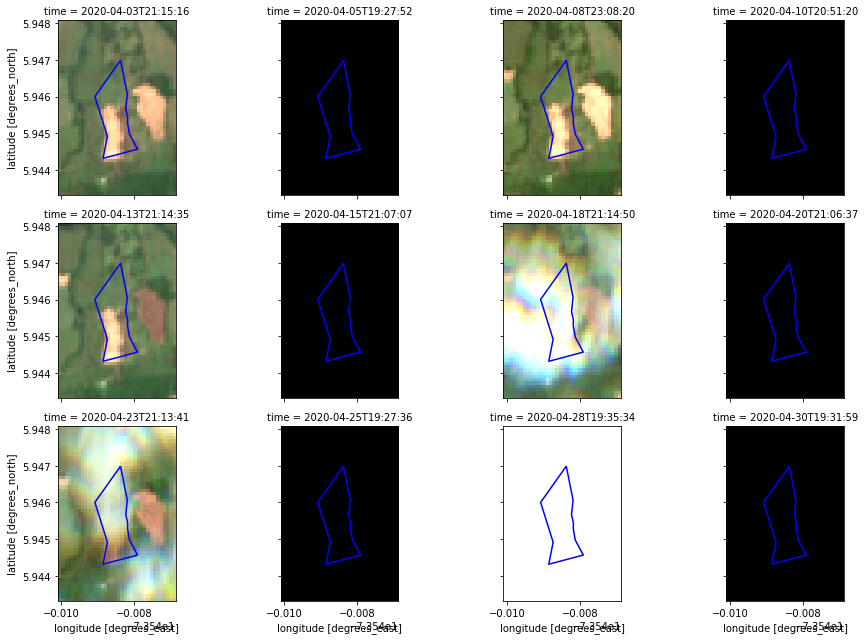

In [28]:
rgb = dataset[["red","green","blue"]].to_array(dim='color')
rgb = rgb.transpose(*(rgb.dims[1:]+rgb.dims[:1]))  # make 'color' the last dimension
img = rgb.plot.imshow(col='time',col_wrap=4,add_colorbar=False,vmin=0,vmax=1500)

for axes in img.axes.flat:
    df_polygon.boundary.plot(ax=axes,markersize=20,color='blue',marker='o')

## 3. Cálculo del compuesto de medianas

El compuesto de medianas (Median Composite), se basa en el cálculo de la mediana  de  cada  píxel  en  una  serie  de  tiempo. 

<img src="https://raw.githubusercontent.com/DonAurelio/open-datacube-bac-training/main/docs/composite.png" alt="Compuesto de medianas" width="60%">

El cálculo del compuesto de medianas comprende dos pasos: 

1. **Aplicación de la máscara de nubes**
2. **Generación del compuesto**

Funciones auxiliares para el cálculo del compuesto

In [14]:
def unpack_bits(land_cover_endcoding, data_array, cover_type):
    """
    Description:
        Unpack bits for end of ls7 and ls8 functions 
    -----
    Input:
        land_cover_encoding(dict hash table) land cover endcoding provided by ls7 or ls8
        data_array( xarray DataArray)
        cover_type(String) type of cover
    Output:
        unpacked DataArray
    """
    data = data_array.data
    if isinstance(data, np.ndarray):
        boolean_mask = np.isin(data, land_cover_endcoding[cover_type]) 
    elif isinstance(data, dask.array.core.Array):
        boolean_mask = dask.array.isin(data, land_cover_endcoding[cover_type])
    return xr.DataArray(boolean_mask.astype(bool),
                        coords = data_array.coords,
                        dims = data_array.dims,
                        name = cover_type + "_mask",
                        attrs = data_array.attrs)

def s2_unpack_qa(data_array , cover_type):

    land_cover_endcoding = dict( 
        no_data                 =[0] ,
        saturated_or_defective  =[1],
        dark_area               =[2],
        cloud_shadow            =[3],
        vegetation              =[4],
        not_vegetated           =[5],
        water                   =[6],
        unclassified            =[7],
        cloud_medium_prob       =[8],
        cloud_high_prob         =[9],
        thin_cirrus             =[10],
        snow                    =[11]
    )
    return unpack_bits(land_cover_endcoding, data_array, cover_type)

def qa_clean_mask(dataset, platform, cover_types=['vegetation', 'not_vegetated']):
    """
    Returns a clean_mask for `dataset` that masks out various types of terrain cover using the
    Landsat pixel_qa band. Note that Landsat masks specify what to keep, not what to remove.
    This means that using `cover_types=['clear', 'water']` should keep only clear land and water.

    See "pixel_qa band" here: https://landsat.usgs.gov/landsat-surface-reflectance-quality-assessment
    and Section 7 here: https://landsat.usgs.gov/sites/default/files/documents/lasrc_product_guide.pdf.

    Parameters
    ----------
    dataset: xarray.Dataset
        An xarray (usually produced by `datacube.load()`) that contains a `pixel_qa` data
        variable.
    platform: str
        A string denoting the platform to be used. Can be "LANDSAT_5", "LANDSAT_7", or
        "LANDSAT_8".
    cover_types: list
        A list of the cover types to include. Adding a cover type allows it to remain in the masked data.
        Cover types for all Landsat platforms include:
        ['fill', 'clear', 'water', 'shadow', 'snow', 'cloud', 'low_conf_cl', 'med_conf_cl', 'high_conf_cl'].

        'fill' removes "no_data" values, which indicates an absense of data. This value is -9999 for Landsat platforms.
        Generally, don't use 'fill'.
        'clear' allows only clear terrain. 'water' allows only water. 'shadow' allows only cloud shadows.
        'snow' allows only snow. 'cloud' allows only clouds, but note that it often only selects cloud boundaries.
        'low_conf_cl', 'med_conf_cl', and 'high_conf_cl' denote low, medium, and high confidence in cloud coverage.
        'low_conf_cl' is useful on its own for only removing clouds, however, 'clear' is usually better suited for this.
        'med_conf_cl' is useful in combination with 'low_conf_cl' to allow slightly heavier cloud coverage.
        Note that 'med_conf_cl' and 'cloud' are very similar.
        'high_conf_cl' is useful in combination with both 'low_conf_cl' and 'med_conf_cl'.

        For Landsat 8, there are more cover types: ['low_conf_cir', 'high_conf_cir', 'terrain_occ'].
        'low_conf_cir' and 'high_conf_cir' denote low and high confidence in cirrus clouds.
        'terrain_occ' allows only occluded terrain.

    Returns
    -------
    clean_mask: xarray.DataArray
        An xarray DataArray with the same number and order of coordinates as in `dataset`.
    """
    processing_options = {
        "SENTINEL_2": s2_unpack_qa
    }

    clean_mask = None
    # Keep all specified cover types (e.g. 'clear', 'water'), so logically or the separate masks.
    for i, cover_type in enumerate(cover_types):
        cover_type_clean_mask = processing_options[platform](dataset.scl, cover_type)
        clean_mask = cover_type_clean_mask if i == 0 else (clean_mask | cover_type_clean_mask)
    return clean_mask

### Aplicación de la máscara de nubes

Durante el proceso de corrección de las imágenes satelitales Sentinel 2 se genera una banda de calidad llamada `scl`. Esta banda de calidad es el resultado de la ejecución de varíos algoirtmos especializados de detección de coberturas específicas. Más información sobre estos algoritmos se muestra [aquí](https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm). 

La tabla mostrada a continuación, presenta los valores de la banda de calidad `scl`. Es en base a esta banda que se aplica el algoirtmo de enmascaramiento de nubes (remover las nubes). 

| Atributo                 | Valor del Píxel |
|--------------------------|-----------------|
| No Data                  | 0               |
| Saturated or defective   | 1               |
| Dark area Pixels         | 2               |
| Cloud Shadows            | 3               |
| Vegetation               | 4               |
| Not vegetated            | 5               |
| Water                    | 6               |
| Unclassified             | 7               |
| Cloud Medium probability | 8               |
| Cloud High probability   | 9               |
| Thin Cirrus              | 10              |
| Snow                     | 11              |

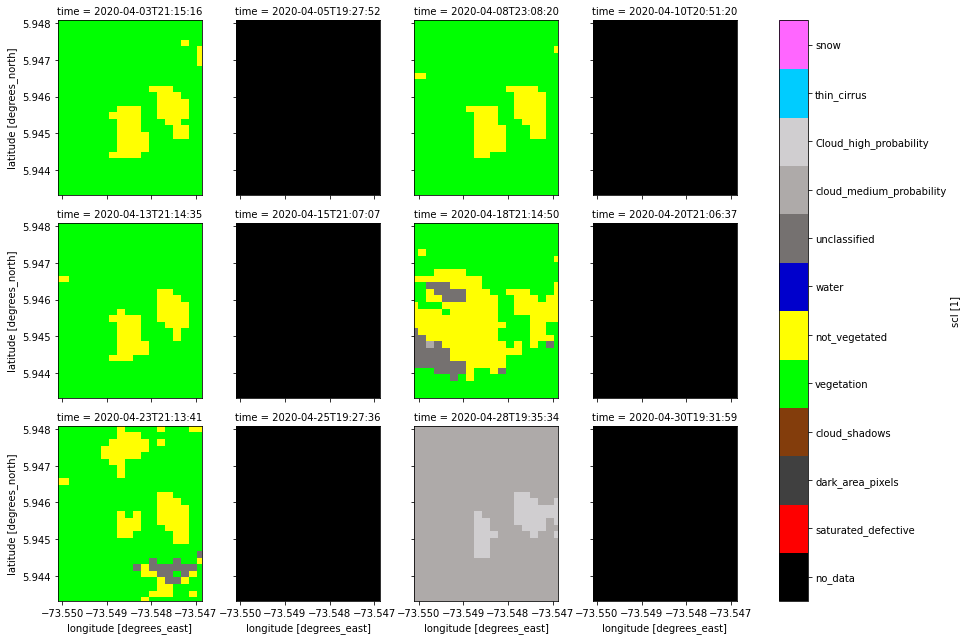

In [46]:
cmap = mpl.colors.ListedColormap(
    [
        '#000000', 
        '#fe0000',
        '#404040', 
        '#833d0c', 
        '#00ff01', 
        '#ffff01', 
        '#0000cc', 
        '#757170', 
        '#aeaaa9', 
        '#d0ced0', 
        '#00ccff', 
        '#ff66ff'
    ]
)

# Rango de valores establecidos para cada color
bounds = [0,1,2,3,4,5,6,7,8,9,10,11,12]

# Genera una capa de normalización de los datos basada en los intérvalos establecidos en 'bounds'
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# Generación de la imágen
img = dataset.scl.plot(col='time',col_wrap=4, cmap=cmap, norm=norm)

classification_labels = [
    'no_data',
    'saturated_defective',
    'dark_area_pixels',
    'cloud_shadows',
    'vegetation',
    'not_vegetated',
    'water',
    'unclassified',
    'cloud_medium_probability',
    'Cloud_high_probability',
    'thin_cirrus',
    'snow'
]

# Permite centrar las etiquetas de los colores en el colorbar
classification_labels_ticks = np.linspace(0.5, 11.5, num=12)

# Configuración de las etiquetas de la barra de colores
img.cbar.set_ticks(classification_labels_ticks)
img.cbar.set_ticklabels(classification_labels)

En nuetro caso particular, estamos interesados en píxeles que presentan probabilidades altas de ser vegetación. Por lo tanto en nuestra máscara de nubes indicamos que deseamos dejar esto píxeles (`qa_clean_mask(dataset,platform='SENTINEL_2',cover_types=['vegetation'])`).

In [47]:
# Generación máscara para valores inválidos
mask_nan = ~np.isnan(dataset)
mask_inf = ~np.isinf(dataset)

# Generación máscara de nubes
clean_mask = qa_clean_mask(dataset,platform='SENTINEL_2',cover_types=['vegetation'])

# Aplicación de la máscara de nubes
clean_dataset = dataset.where(clean_mask & mask_nan & mask_inf)
clean_dataset

<xarray.Dataset>
Dimensions:      (latitude: 53, longitude: 36, time: 12)
Coordinates:
  * time         (time) datetime64[ns] 2020-04-03T21:15:16 ... 2020-04-30T19:...
  * latitude     (latitude) float64 5.948 5.948 5.948 ... 5.944 5.943 5.943
  * longitude    (longitude) float64 -73.55 -73.55 -73.55 ... -73.55 -73.55
    spatial_ref  int32 4326
Data variables:
    red          (time, latitude, longitude) float64 845.0 830.0 ... nan nan
    blue         (time, latitude, longitude) float64 654.0 593.0 ... nan nan
    green        (time, latitude, longitude) float64 881.0 813.0 ... nan nan
    nir          (time, latitude, longitude) float64 2.314e+03 2.302e+03 ... nan
    swir1        (time, latitude, longitude) float64 2.142e+03 2.074e+03 ... nan
    swir2        (time, latitude, longitude) float64 1.338e+03 1.317e+03 ... nan
    scl          (time, latitude, longitude) float64 4.0 4.0 4.0 ... nan nan nan
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

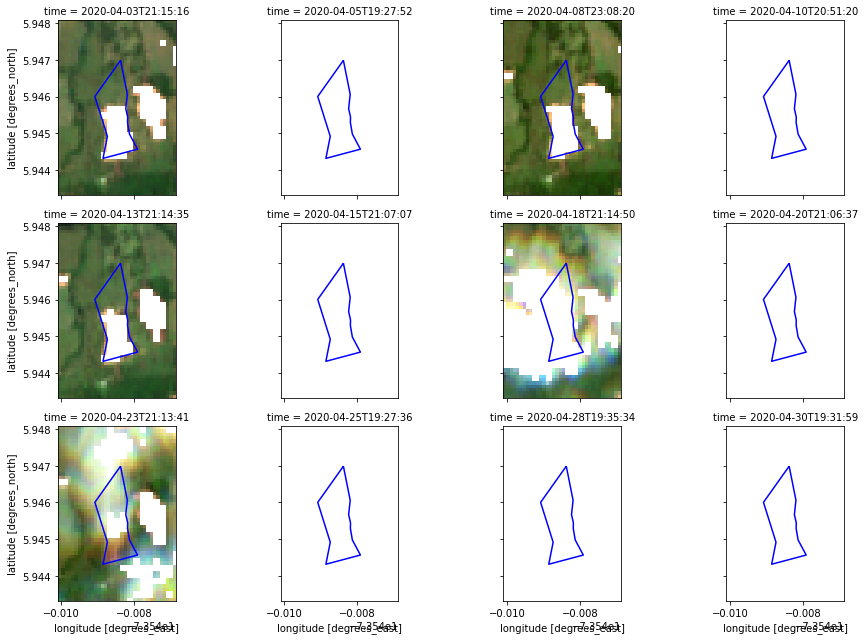

In [48]:
rgb = clean_dataset[["red","green","blue"]].to_array(dim='color')
rgb = rgb.transpose(*(rgb.dims[1:]+rgb.dims[:1]))  # make 'color' the last dimension
img = rgb.plot.imshow(col='time',col_wrap=4,add_colorbar=False,vmin=0,vmax=1500)

for axes in img.axes.flat:
    df_polygon.boundary.plot(ax=axes,markersize=20,color='blue',marker='o')

### Aplicación del compuesto de medianas 

In [25]:
median_composite = clean_dataset.median('time', skipna=True)
median_composite

<xarray.Dataset>
Dimensions:      (latitude: 53, longitude: 36)
Coordinates:
  * latitude     (latitude) float64 5.948 5.948 5.948 ... 5.944 5.943 5.943
  * longitude    (longitude) float64 -73.55 -73.55 -73.55 ... -73.55 -73.55
    spatial_ref  int32 4326
Data variables:
    red          (latitude, longitude) float64 665.0 612.0 ... 747.0 1.086e+03
    blue         (latitude, longitude) float64 466.0 429.0 427.0 ... 536.0 646.0
    green        (latitude, longitude) float64 741.0 694.0 669.0 ... 740.0 969.0
    nir          (latitude, longitude) float64 2.324e+03 2.302e+03 ... 2.852e+03
    swir1        (latitude, longitude) float64 2.142e+03 2.074e+03 ... 2.49e+03
    swir2        (latitude, longitude) float64 1.338e+03 1.317e+03 ... 1.542e+03
    scl          (latitude, longitude) float64 4.0 4.0 4.0 4.0 ... 4.0 4.0 4.0

<AxesSubplot:title={'center':'spatial_ref = 4326'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

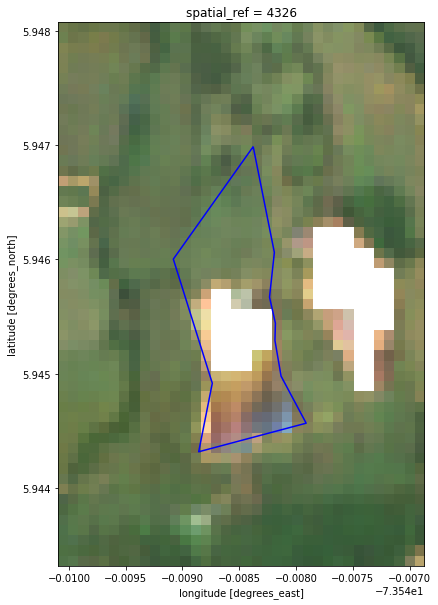

In [49]:
rgb = median_composite[["red","green","blue"]].to_array(dim='color')
rgb = rgb.transpose(*(rgb.dims[1:]+rgb.dims[:1]))  # make 'color' the last dimension
img = rgb.plot.imshow(add_colorbar=False,vmin=0,vmax=1500,figsize=(10,10))

df_polygon.boundary.plot(ax=img.axes,markersize=20,color='blue',marker='o')

## 4. Guardar resultados de análisis en fortamto netcdf

Guardar resultados de análisis en un archivo .nc

In [50]:
median_composite.to_netcdf('mediana.nc')

## 5. Guardar resultados de análisis en formato geotiff

Funciones requeridas para guardar información en geotiff

In [51]:
"""
Las funciones mostradas a continuación fueron tomadas de 
https://github.com/ceos-seo/data_cube_notebooks
"""

def _get_transform_from_xr(data, x_coord='longitude', y_coord='latitude'):
    """Create a geotransform from an xarray.Dataset or xarray.DataArray.
    """

    from rasterio.transform import from_bounds
    geotransform = from_bounds(data[x_coord][0], data[y_coord][-1],
                               data[x_coord][-1], data[y_coord][0],
                               len(data[x_coord]), len(data[y_coord]))
    return geotransform

def write_geotiff_from_xr(tif_path, data, bands=None, no_data=-9999, crs="EPSG:4326",
                          x_coord='longitude', y_coord='latitude'):
    """
    NOTE: Instead of this function, please use `import_export.export_xarray_to_geotiff()`.
    Export a GeoTIFF from an `xarray.Dataset`.
    Parameters
    ----------
    tif_path: string
        The path to write the GeoTIFF file to. You should include the file extension.
    data: xarray.Dataset or xarray.DataArray
    bands: list of string
        The bands to write - in the order they should be written.
        Ignored if `data` is an `xarray.DataArray`.
    no_data: int
        The nodata value.
    crs: string
        The CRS of the output.
    x_coord, y_coord: string
        The string names of the x and y dimensions.
    """
    if isinstance(data, xr.DataArray):
        height, width = data.sizes[y_coord], data.sizes[x_coord]
        count, dtype = 1, data.dtype
    else:
        if bands is None:
            bands = list(data.data_vars.keys())
        else:
            assrt_msg_begin = "The `data` parameter is an `xarray.Dataset`. "
            assert isinstance(bands, list), assrt_msg_begin + "Bands must be a list of strings."
            assert len(bands) > 0 and isinstance(bands[0], str), assrt_msg_begin + "You must supply at least one band."
        height, width = data.dims[y_coord], data.dims[x_coord]
        count, dtype = len(bands), data[bands[0]].dtype
    with rasterio.open(
            tif_path,
            'w',
            driver='GTiff',
            height=height,
            width=width,
            count=count,
            dtype=dtype,
            crs=crs,
            transform=_get_transform_from_xr(data, x_coord=x_coord, y_coord=y_coord),
            nodata=no_data) as dst:
        if isinstance(data, xr.DataArray):
            dst.write(data.values, 1)
        else:
            for index, band in enumerate(bands):
                dst.write(data[band].values, index + 1)
    dst.close()

Guardar resultados de análisis en un archivo .tif

In [52]:
write_geotiff_from_xr(
    tif_path='mediana.tif', 
    data=median_composite, 
    # El orden de las bandas es importante al momento de ser visualizada la imágen en una herramienta GIS
    bands=['red','green','blue',], 
    no_data=-9999, 
    crs="EPSG:4326",
    x_coord='longitude',
    y_coord='latitude'
)